# Regularization for linear classifier models

In [1]:
import numpy as np
import pandas as pd

from sklearn.linear_model import LinearRegression, Ridge, Lasso, LogisticRegression
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.datasets import load_boston, load_iris, load_wine, load_digits, \
                             load_breast_cancer, load_diabetes
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, precision_score, recall_score, log_loss, mean_absolute_error

from pandas.api.types import is_numeric_dtype

import matplotlib.pyplot as plt
import matplotlib as mpl

%config InlineBackend.figure_format = 'retina'

np.random.seed(999)

def score(X, y, model, n=10):
    train_scores = []
    test_scores = []
    for i in range(n):
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
        model.fit(X_train, y_train)
        train_score = model.score(X_train, y_train)
        train_scores.append(train_score)
        test_score = model.score(X_test, y_test)
        test_scores.append(test_score)
    return np.mean(train_scores), np.mean(test_scores)

def normalize(X):
    for colname in X.columns:
        if is_numeric_dtype(X[colname]):
            u = np.mean(X[colname])
            s = np.std(X[colname])
            X[colname] = (X[colname] - u) / s

In [2]:
def plot_coef(beta, which, yrange=(-20_000, 20_000),fontsize=10, xlabel=True, ylabel=True, tick_format='{x:.1f}', ax=None):
    if ax is None:
        fig,ax = plt.subplots(1,1,figsize=(4.5,2.5))
    ax.bar(range(len(beta)),beta)
    if xlabel:
        ax.set_xlabel("Coefficient $\\beta_i$ for $i \\geq 1$", fontsize=fontsize)
    if ylabel:
        ax.set_ylabel("Coefficient value", fontsize=fontsize)
    if yrange is not None:
        ax.set_ylim(*yrange)
    ax.tick_params(axis='both', which='major', labelsize=fontsize)
    plt.gca().yaxis.set_major_formatter(mpl.ticker.StrMethodFormatter(tick_format))
    ax.set_title(f"{which} $\\overline{{\\beta}}$={np.mean(beta):.2f}, $\\sigma(\\beta)$={np.std(beta):.2f}", fontsize=fontsize)
    
# def plot_coef(B):
#     plt.figure(figsize=(4.5,2.5))
#     plt.bar(range(len(B)),B)
#     plt.xlabel("Regression coefficient $\\beta_i$ for $i>0$", fontsize=10)
#     plt.ylabel("Regression coefficient value", fontsize=10)

## Wine data for classes 0,1

In [3]:
wine = load_wine()
df_wine = pd.DataFrame(data=wine.data, columns=wine.feature_names)
df_wine['y'] = wine.target
df_wine = df_wine[df_wine['y']<2] # Only do 2-class problem {0,1}
X = df_wine.drop('y', axis=1)

# Try with first 3 features
#X = X.iloc[:,0:3]

y = df_wine['y']
print(f"{len(X)} records for classes {{0,1}} from {len(wine.data)} records")

130 records for classes {0,1} from 178 records


In [4]:
X.head()

,alcohol,malic_acid,ash,alcalinity_of_ash,magnesium,total_phenols,flavanoids,nonflavanoid_phenols,proanthocyanins,color_intensity,hue,od280/od315_of_diluted_wines,proline
0,14.23,1.71,2.43,15.6,127.0,2.80,3.06,0.28,2.29,5.64,1.04,3.92,1065.0
1,13.20,1.78,2.14,11.2,100.0,2.65,2.76,0.26,1.28,4.38,1.05,3.40,1050.0
2,13.16,2.36,2.67,18.6,101.0,2.80,3.24,0.30,2.81,5.68,1.03,3.17,1185.0
3,14.37,1.95,2.50,16.8,113.0,3.85,3.49,0.24,2.18,7.80,0.86,3.45,1480.0
4,13.24,2.59,2.87,21.0,118.0,2.80,2.69,0.39,1.82,4.32,1.04,2.93,735.0


In [5]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=999)

### Baseline sklearn no reg

In [6]:
lm = LogisticRegression(penalty='none', solver='lbfgs', max_iter=1000)
lm.fit(X_train, y_train)
lm.score(X_train, y_train), lm.score(X_test, y_test)

(1.0, 0.8076923076923077)

In [7]:
log_loss(y_train, lm.predict_proba(X_train)[:,1]), log_loss(y_test, lm.predict_proba(X_test)[:,1])

(2.70295930594369e-09, 6.6421338911313)

In [8]:
mean_absolute_error(y_train, lm.predict_proba(X_train)[:,1]), mean_absolute_error(y_test, lm.predict_proba(X_test)[:,1])

(2.7029581642251546e-09, 0.19230769230769232)

In [9]:
lm.coef_[0]

array([ 592.09212403, -672.58668662, -312.54822389,   52.4281717 ,
          2.25150006,  -75.4160036 , -215.85493514,    2.84012372,
        118.57427682, -305.80844308,  130.0651981 ,  -82.65002733,
         -6.36232675])

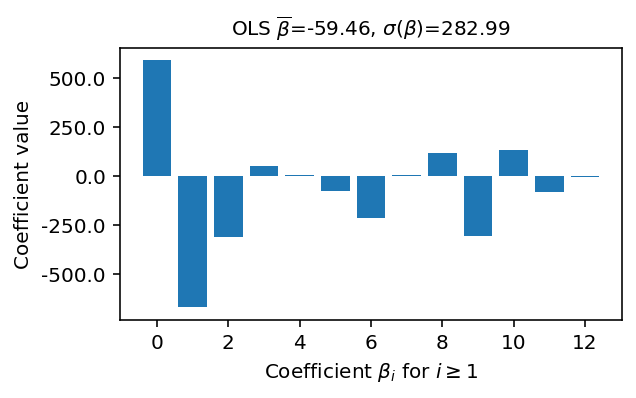

In [10]:
plot_coef(lm.coef_[0], "OLS", yrange=None)
#plt.gca().yaxis.set_major_formatter(mpl.ticker.StrMethodFormatter('{x:.1f}'))

## normalize and try again

In [11]:
X_train, X_test, y_train, y_test = train_test_split(X.copy(), y, test_size=0.2, random_state=999)
normalize(X_train)
normalize(X_test)

lm = LogisticRegression(penalty='none', solver='lbfgs', max_iter=1000)
lm.fit(X_train, y_train)
lm.score(X_train, y_train), lm.score(X_test, y_test)

(1.0, 0.9615384615384616)

In [12]:
log_loss(y_train, lm.predict_proba(X_train)[:,1]), log_loss(y_test, lm.predict_proba(X_test)[:,1])

(1.0314028840361334e-06, 0.04692063962581648)

In [13]:
mean_absolute_error(y_train, lm.predict_proba(X_train)[:,1]), mean_absolute_error(y_test, lm.predict_proba(X_test)[:,1])

(1.0313903314335205e-06, 0.027145013380507045)

In [14]:
lm.coef_[0]

array([ -8.930838  ,  -5.06218822,  -9.303276  ,   9.2063364 ,
        -1.67026221,  -0.48417169,  -1.56940387,   3.66934246,
         2.75407023,  -1.42959803,  -0.68040913,  -3.94200355,
       -16.62809887])

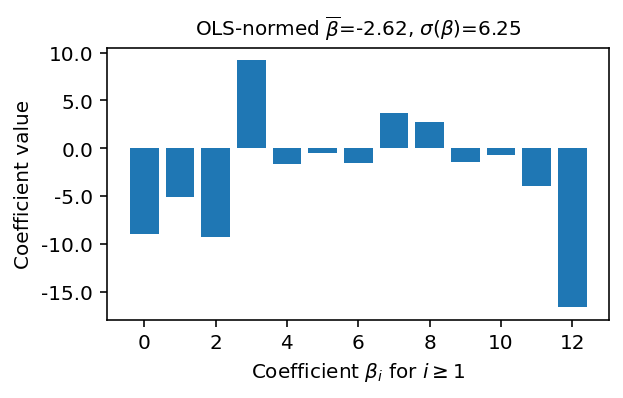

In [15]:
plot_coef(lm.coef_[0], "OLS-normed", yrange=None)

### With L1 reg

In [16]:
lm = LogisticRegression(C=1/.1, penalty='l1', solver='liblinear', max_iter=1000)
lm.fit(X_train, y_train)
lm.score(X_train, y_train), lm.score(X_test, y_test)

(1.0, 0.9615384615384616)

In [17]:
log_loss(y_train, lm.predict_proba(X_train)[:,1]), log_loss(y_test, lm.predict_proba(X_test)[:,1])

(0.004475071534701435, 0.058486500607002063)

In [18]:
mean_absolute_error(y_train, lm.predict_proba(X_train)[:,1]), mean_absolute_error(y_test, lm.predict_proba(X_test)[:,1])

(0.004378156712586686, 0.03323075243668071)

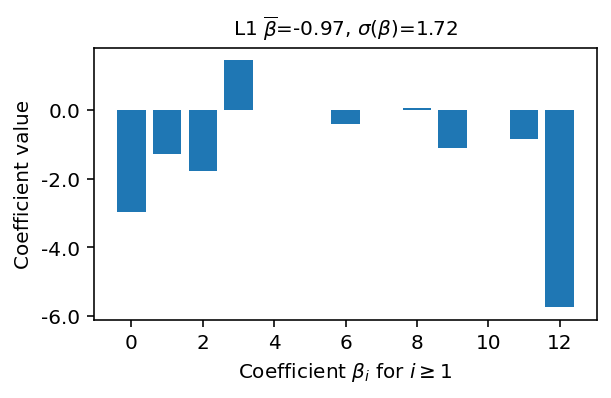

In [19]:
plot_coef(lm.coef_[0], "L1", yrange=None)

We pushed coefficients to 0 by increasing $lambda$ (inverse of C)

## L2

In [20]:
lm = LogisticRegression(C=1/.1, penalty='l2', solver='liblinear')
lm.fit(X_train, y_train)
lm.score(X_train, y_train), lm.score(X_test, y_test)

(1.0, 1.0)

In [21]:
log_loss(y_train, lm.predict_proba(X_train)), log_loss(y_test, lm.predict_proba(X_test))

(0.008751067258281868, 0.03245743925572692)

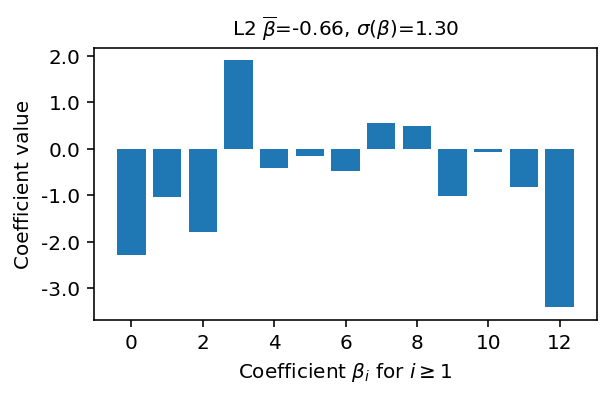

In [22]:
plot_coef(lm.coef_[0], "L2", yrange=None)

## MNIST classification

In [23]:
digits = pd.read_csv("../../data/mnist-10k-sample.csv")
images = digits.drop('digit', axis=1) # get just pixels
targets = digits['digit']             # get just digit value

In [24]:
def imgrid(images,targets):
    fig, axes = plt.subplots(5, 5, figsize=(4, 4)) # make 5x5 grid of plots
    for i, ax in enumerate(axes.flat):
        img_as_row = images.iloc[i].values
        img28x28 = img_as_row.reshape(28,28)
        ax.axis('off') # don't show x, y axes
        ax.imshow(img28x28, cmap='Greys')
        ax.text(0, 8, targets[i], color='#313695', fontsize=18)

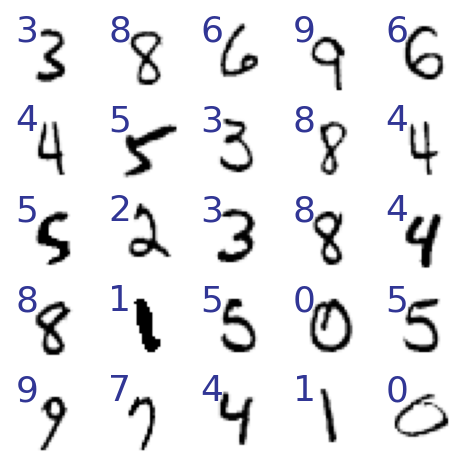

In [25]:
imgrid(images,targets=targets)

In [26]:
zeros  = images[targets==0] # find all "0" images
ones   = images[targets==1] # find all "1" images
sevens = images[targets==7] # find all "7" images
fours = images[targets==4] # find all "4" images
nines = images[targets==9] # find all "9" images

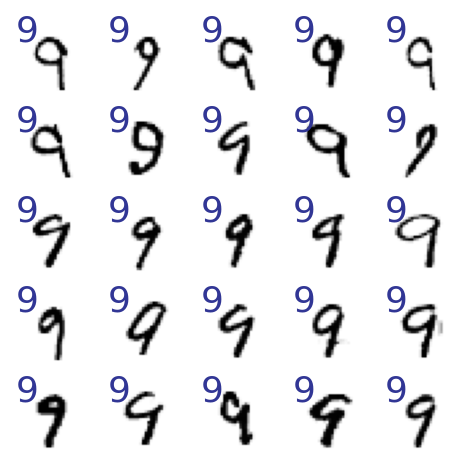

In [27]:
imgrid(nines, targets[targets==9].values)

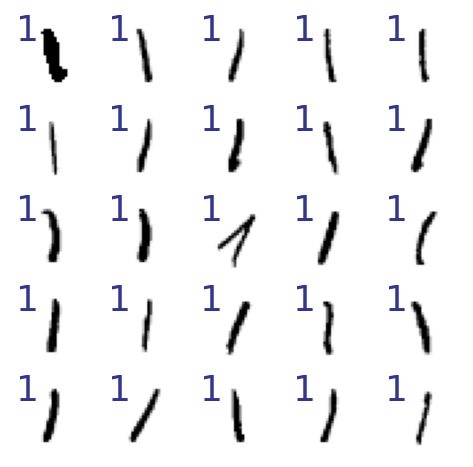

In [28]:
imgrid(ones, targets[targets==1].values)

In [29]:
np.unique(ones.iloc[1]) # greyscale values 0..1

array([0.        , 0.04296875, 0.05078125, 0.09375   , 0.09765625,
       0.140625  , 0.15625   , 0.16015625, 0.171875  , 0.27734375,
       0.296875  , 0.30078125, 0.37109375, 0.375     , 0.41015625,
       0.46484375, 0.4765625 , 0.52734375, 0.54296875, 0.546875  ,
       0.58203125, 0.5859375 , 0.6484375 , 0.66015625, 0.73046875,
       0.7578125 , 0.76171875, 0.76953125, 0.7890625 , 0.796875  ,
       0.80078125, 0.82421875, 0.8359375 , 0.8515625 , 0.890625  ,
       0.93359375, 0.96875   , 0.9765625 , 0.98046875, 0.9921875 ])

In [30]:
# combine 4s and 9s to get subset of data; fours' class is 0, nines' class is 1
print(f"{len(fours)} fours and {len(nines)} nines")
X = np.concatenate([fours, nines], axis=0)
y = np.concatenate([np.zeros(len(fours)), np.ones(len(nines))], axis=0)

983 fours and 961 nines


In [31]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

### Fit model

In [32]:
lgr = LogisticRegression(penalty='none', solver='lbfgs')
lgr.fit(X_train, y_train)
lgr.score(X_train, y_train), lgr.score(X_test, y_test)

(1.0, 0.9562982005141388)

In [33]:
log_loss(y_train, lgr.predict_proba(X_train)[:,1]), log_loss(y_test, lgr.predict_proba(X_test)[:,1])

(2.2837570963968752e-07, 1.023728272448256)

### Evaluating results

What the predictions should be (0=one, 1=seven).

How many are off?  Count to get accuracy:

In [34]:
y_pred = lgr.predict(X_test)
np.sum(np.array(y_pred) != np.array(y_test)), len(y_pred)

(17, 389)

In [35]:
sum(np.abs(lgr.coef_[0]) < 1e-5) # how many coefficients are close to 0?

231

Text(0, 0.5, 'Regression coefficient value')

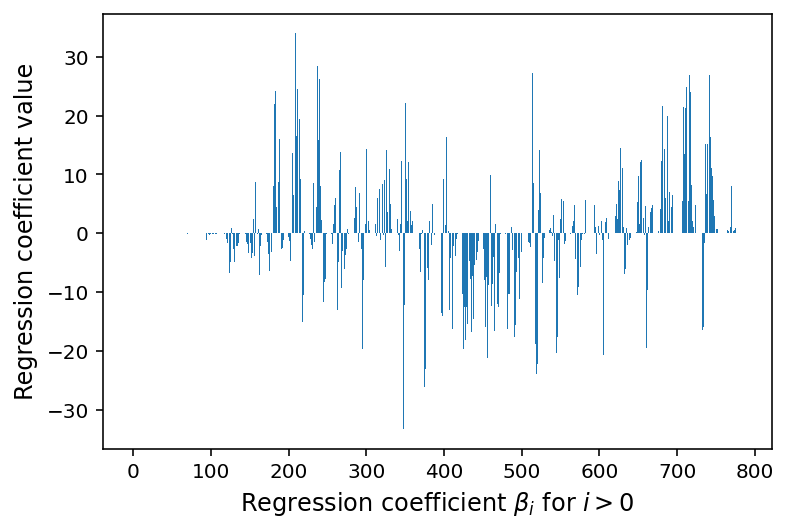

In [36]:
plt.bar(range(len(lgr.coef_[0,:])),lgr.coef_[0,:])
plt.xlabel("Regression coefficient $\\beta_i$ for $i>0$", fontsize=12)
plt.ylabel("Regression coefficient value", fontsize=12)

In [37]:
cm = confusion_matrix(y_test, y_pred)
print(cm)
P = precision_score(y_test, y_pred)
R = recall_score(y_test, y_pred)
P, R

[[181  10]
 [  7 191]]


(0.9502487562189055, 0.9646464646464646)

## L1 Regularization

In [38]:
for lmbda in [1e-7, 0.001, 1, 5, 10, 100, 150]:
    lm = LogisticRegression(C=1/lmbda, penalty='l1', solver='liblinear')
    lm.fit(X_train, y_train)
    y_pred = lm.predict(X_test)
    P = precision_score(y_test, y_pred)
    R = recall_score(y_test, y_pred)
    print(f"lambda={lmbda:>11} gets training accuracy {lm.score(X_train, y_train):.2f} & testing {lm.score(X_test, y_test):.2f} precision={P:.2f}, recall={R:.2f}")

lambda=      1e-07 gets training accuracy 1.00 & testing 0.96 precision=0.96, recall=0.95
lambda=      0.001 gets training accuracy 1.00 & testing 0.97 precision=0.97, recall=0.97
lambda=          1 gets training accuracy 0.99 & testing 0.95 precision=0.96, recall=0.95
lambda=          5 gets training accuracy 0.97 & testing 0.96 precision=0.97, recall=0.95
lambda=         10 gets training accuracy 0.96 & testing 0.96 precision=0.97, recall=0.95
lambda=        100 gets training accuracy 0.88 & testing 0.90 precision=0.90, recall=0.91
lambda=        150 gets training accuracy 0.88 & testing 0.90 precision=0.87, recall=0.95


In [39]:
lmbda=0.001
lm = LogisticRegression(C=1/lmbda, penalty='l1', solver='liblinear')
lm.fit(X_train, y_train)
sum(np.abs(lm.coef_[0]) < 1e-5) # how many close to 0?

423

In [40]:
log_loss(y_train, lm.predict_proba(X_train)[:,1]), log_loss(y_test, lm.predict_proba(X_test)[:,1])

(0.0002119955969987391, 0.23152779599399625)

In [41]:
mean_absolute_error(y_train, lm.predict_proba(X_train)[:,1]), mean_absolute_error(y_test, lm.predict_proba(X_test)[:,1])

(0.0002115788365902717, 0.03318684027402381)

Text(0, 0.5, 'Regression coefficient value')

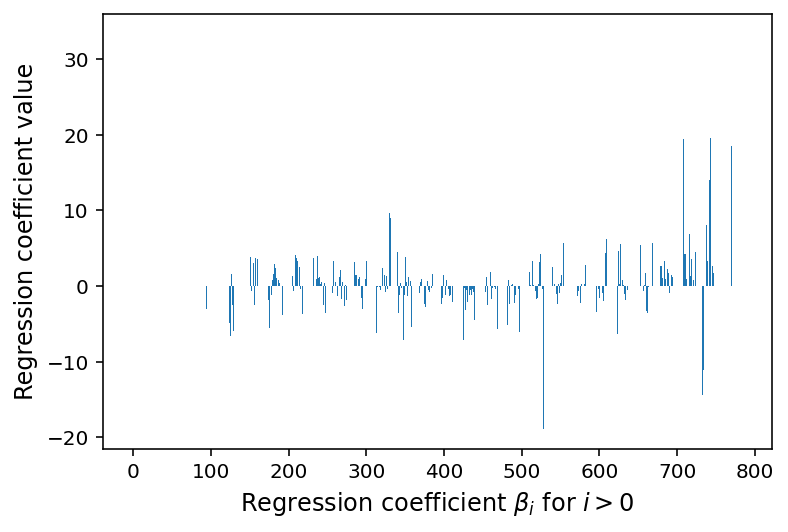

In [42]:
plt.bar(range(len(lm.coef_[0,:])),lm.coef_[0,:])
plt.xlabel("Regression coefficient $\\beta_i$ for $i>0$", fontsize=12)
plt.ylabel("Regression coefficient value", fontsize=12)

## L2 Regularization

In [43]:
for lmbda in [1e-7, 0.001, 1, 5, 10, 100, 150]:
    lm = LogisticRegression(C=1/lmbda, penalty='l2', solver='liblinear')
    lm.fit(X_train, y_train)
    y_pred = lm.predict(X_test)
    P = precision_score(y_test, y_pred)
    R = recall_score(y_test, y_pred)
    print(f"lambda={lmbda:>11} gets training accuracy {lm.score(X_train, y_train):.2f} & testing {lm.score(X_test, y_test):.2f} precision={P:.2f}, recall={R:.2f}")

lambda=      1e-07 gets training accuracy 1.00 & testing 0.96 precision=0.95, recall=0.97
lambda=      0.001 gets training accuracy 1.00 & testing 0.96 precision=0.95, recall=0.97
lambda=          1 gets training accuracy 0.99 & testing 0.96 precision=0.95, recall=0.96
lambda=          5 gets training accuracy 0.98 & testing 0.96 precision=0.97, recall=0.95
lambda=         10 gets training accuracy 0.98 & testing 0.96 precision=0.97, recall=0.95
lambda=        100 gets training accuracy 0.96 & testing 0.95 precision=0.96, recall=0.94
lambda=        150 gets training accuracy 0.96 & testing 0.96 precision=0.96, recall=0.95


In [44]:
lmbda=1 # this one looks to be pretty good
lm = LogisticRegression(C=1/lmbda, penalty='l2', solver='liblinear')
lm.fit(X_train, y_train)
sum(np.abs(lm.coef_[0]) < 1e-5) # how many close to 0?

233

In [45]:
log_loss(y_train, lm.predict_proba(X_train)[:,1]), log_loss(y_test, lm.predict_proba(X_test)[:,1])

(0.03464292300775971, 0.08587093937853515)

In [46]:
mean_absolute_error(y_train, lm.predict_proba(X_train)[:,1]), mean_absolute_error(y_test, lm.predict_proba(X_test)[:,1])

(0.029318151650388338, 0.045731307638433895)

Text(0, 0.5, 'Regression coefficient value')

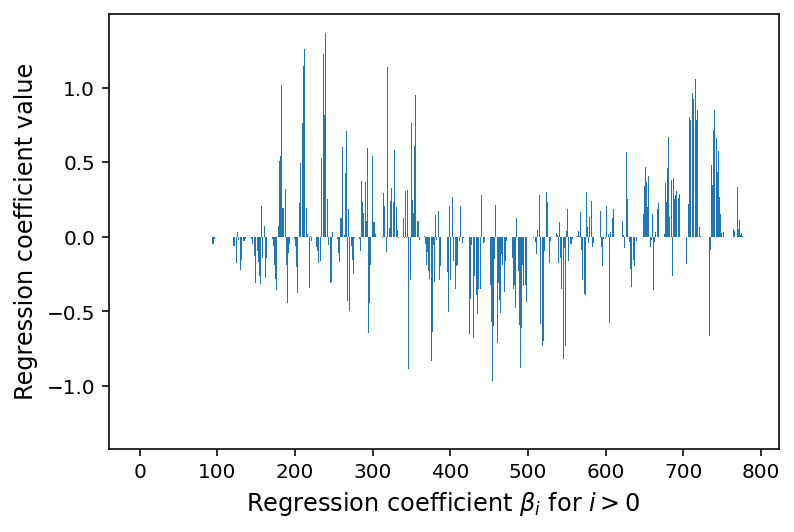

In [47]:
plt.bar(range(len(lm.coef_[0,:])),lm.coef_[0,:])
plt.xlabel("Regression coefficient $\\beta_i$ for $i>0$", fontsize=12)
plt.ylabel("Regression coefficient value", fontsize=12)

## Breast cancer 

In [48]:
cancer = load_breast_cancer()
df_cancer = pd.DataFrame(data=cancer.data, columns=cancer.feature_names)
df_cancer['y'] = cancer.target
X = df_cancer.drop('y', axis=1)
y = df_cancer['y']
X.shape

(569, 30)

In [49]:
X_train, X_test, y_train, y_test = train_test_split(X.copy(), y, test_size=0.2)

In [50]:
normalize(X_train)
normalize(X_test)

In [51]:
lgr = LogisticRegression(penalty='none', solver='lbfgs')
lgr.fit(X_train, y_train)
lgr.score(X_train, y_train), lgr.score(X_test, y_test)

(1.0, 0.9210526315789473)

In [52]:
log_loss(y_train, lgr.predict_proba(X_train)), log_loss(y_test, lgr.predict_proba(X_test))

(5.213984055030655e-07, 2.7267455048613716)

In [53]:
sum(np.abs(lm.coef_[0]) < 1e-5) # how many close to 0?

233

In [54]:
lmbda=1
lgr = LogisticRegression(C=1/lmbda, penalty='l1', solver='liblinear')
lgr.fit(X_train, y_train)
lgr.score(X_train, y_train), lgr.score(X_test, y_test)

(0.989010989010989, 0.9649122807017544)

In [55]:
log_loss(y_train, lgr.predict_proba(X_train)), log_loss(y_test, lgr.predict_proba(X_test))

(0.04786611531041981, 0.1078635026937078)

In [56]:
sum(np.abs(lgr.coef_[0]) < 1e-5) # how many close to 0?

14

In [57]:
lmbda=5
lgr = LogisticRegression(C=1/lmbda, penalty='l2', solver='liblinear')
lgr.fit(X_train, y_train)
lgr.score(X_train, y_train), lgr.score(X_test, y_test)

(0.9868131868131869, 0.9649122807017544)

In [58]:
log_loss(y_train, lgr.predict_proba(X_train)), log_loss(y_test, lgr.predict_proba(X_test))

(0.06788995028111515, 0.10894505320704685)

In [59]:
sum(np.abs(lgr.coef_[0]) < 1e-5) # how many close to 0?

0

## Paribas

In [60]:
df_par = pd.read_csv("paribas.csv")
df_par = df_par.sample(20_000)
df_par.shape

(20000, 133)

In [61]:
numcols = df_par.columns[[is_numeric_dtype(df_par[c]) for c in df_par.columns]]
df_par = df_par[numcols]
df_par = df_par.dropna(0)
df_par.shape

(10930, 114)

In [62]:
df_par.head(1)

,ID,target,v1,v2,v4,v5,v6,v7,v8,v9,...,v121,v122,v123,v124,v126,v127,v128,v129,v130,v131
92792,185466,1,0.817137,9.06977,5.709188,9.852457,3.03887,2.508834,0.475395,9.937107,...,0.949186,8.930817,1.737644,0.235087,1.199644,2.650177,2.412311,1,0.647888,2.173913


In [63]:
X = df_par.drop('target', axis=1)
y = df_par['target']

In [64]:
X_train, X_test, y_train, y_test = train_test_split(X.copy(), y, test_size=0.2)

In [65]:
normalize(X_train)
normalize(X_test)

In [66]:
lgr = LogisticRegression(solver='liblinear', max_iter=1000)
lgr.fit(X_train, y_train)
lgr.score(X_train, y_train), lgr.score(X_test, y_test)

(0.7537740164684354, 0.7648673376029277)

In [67]:
log_loss(y_train, lgr.predict_proba(X_train)), log_loss(y_test, lgr.predict_proba(X_test))

(0.5092750615867948, 0.5032155300325649)

In [68]:
lmbda=60
lgr = LogisticRegression(C=1/lmbda, penalty='l1', solver='liblinear')
lgr.fit(X_train, y_train)
lgr.score(X_train, y_train), lgr.score(X_test, y_test)

(0.7510292772186642, 0.7657822506861848)

In [69]:
log_loss(y_train, lgr.predict_proba(X_train)), log_loss(y_test, lgr.predict_proba(X_test))

(0.5168624604008182, 0.5039034229645231)

In [70]:
lmbda=60
lgr = LogisticRegression(C=1/lmbda, penalty='l2', solver='liblinear')
lgr.fit(X_train, y_train)
lgr.score(X_train, y_train), lgr.score(X_test, y_test)

(0.7520585544373285, 0.7662397072278133)

In [71]:
log_loss(y_train, lgr.predict_proba(X_train)), log_loss(y_test, lgr.predict_proba(X_test))

(0.5125191148264522, 0.5031419772006848)